# Exploring & Machine Learning for Airbnb Listings in Toronto

Airbnb does not provide open data in the sense of giant databases or dumps that we can work with. However, Inside Airbnb utilizes public information compiled from the Airbnb web-site and analyzes publicly available information about a city's Airbnb's listings, and provides filters and key metrics so we can see how Airbnb is being used in the major cities around the world. Inside Airbnb is an independent, non-commercial set of tools and data that is not associated with or endorsed by Airbnb or any of Airbnb's competitors.

However, the information provided by Inside Airbnb isn't going to be enough for us. We are going to download data from there for our own analysis. 

I will be working with Toronto data. Because I live here and I know some of the neighborhoods here. You are welcome to choose any city you prefer.

We are going to look at Airbnb listings and calendars, and trying to provide some exploratory analysis around predicting listing prices, both for, if we were hypothetically working at Airbnb, and also for a consumer.

[dataset](https://www.kaggle.com/airbnb/seattle#reviews.csv "Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
reviews = pd.read_csv('e:/data/seattle/reviews.csv')
calendar = pd.read_csv('e:/data/seattle/calendar.csv')
listings = pd.read_csv('e:/data/seattle/listings.csv')

### Calender

How busy is it for Airbnb hosts in Toronto?

In [18]:
pd.set_option('display.float_format','{:.2f}'.format)
calendar.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
listing_id,1393570.00,NaN,NaN,NaN,5550111.42,2962273.53,3335.00,3258213.00,6118244.50,8035212.00,10340165.00
date,1393570,365,2016-12-10,3818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
available,1393570,2,t,934542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,934542,669,$150.00,36646,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# calendar = pd.read_csv('calendar.csv.gz')
print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the calendar data.')

We have 365 days and 3818 unique listings in the calendar data.


In [6]:
calendar.date.min(), calendar.date.max()

('2016-01-04', '2017-01-02')

Calendar data covers one year time frame, that is, price and availability every day for the next one year.

In [19]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [20]:
calendar.shape

(1393570, 4)

In [21]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [22]:
calendar.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

f (false) means not available, t(true) means available.

Find out daily average availability for one year. Convert available column to 0 if available and 1 if not.

D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,busy
0,2016-01-04,0.55
1,2016-01-05,0.51
2,2016-01-06,0.52
3,2016-01-07,0.53
4,2016-01-08,0.53


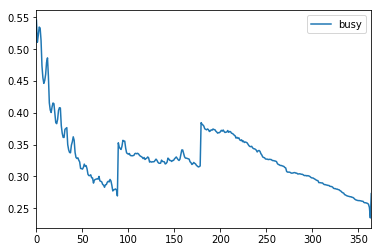

In [42]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date'] = pd.to_datetime(calendar_new['date'])
calendar_new[:5]
ax = calendar_new.plot(kind='line')

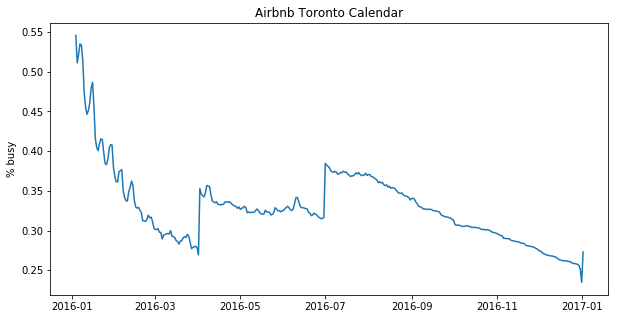

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Toronto Calendar')
plt.ylabel('% busy')
plt.show();

The busiest month in Toronto was Oct which has just passed.The next busy months seems after April and extend to the summer. These are all within our experience and expectations.

### Price on the Calendar

How prices change over the year by month?

In [45]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Remove "$" symbol in price column and convert it to numeric, and convert date to datetime data type.

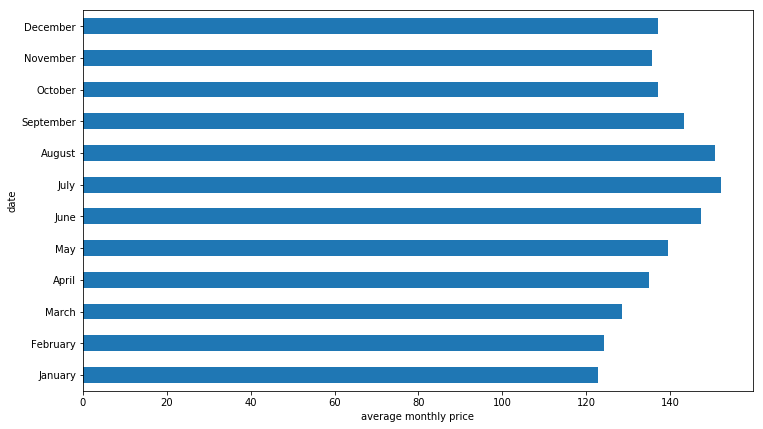

In [46]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=False)['price'].mean()
mean_of_month.plot(kind = 'barh' , figsize = (12,7))
plt.xlabel('average monthly price');

The Airbnb price in Toronto increases in the months of July, August and October. Agreed, these three months are the best months visiting Toronto.

How price changes during day of week?

,dayofweek,price
0,Monday,85.00
1,Tuesday,85.00
2,Wednesday,nan


,listing_id,price
dayofweek,,
Monday,5550111.42,135.68
Tuesday,5550111.42,135.41
Wednesday,5550111.42,135.45


([<matplotlib.axis.XTick at 0x237db2e6cc0>,
 <a list of 7 Text xticklabel objects>)

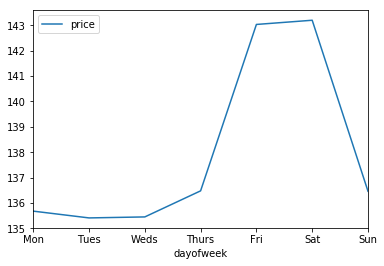

In [49]:
calendar['dayofweek'] = calendar.date.dt.weekday_name
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek','price']]
price_week[:3]
price_week = calendar.groupby(['dayofweek']).mean().reindex(cats)
price_week[:3]
price_week.drop('listing_id', axis=1, inplace=True)
price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)

Fridays and Saturdays are over $10 more expensive than the rest of the week.

### Listings

#### Number of listings in each neighbourhood

In [50]:
listings[:3]
print('We have', listings.id.nunique(), 'listings in the listing data.')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.00,f,nan,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.00,f,nan,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.00,f,nan,WASHINGTON,f,strict,f,f,2,1.15


We have 3818 listings in the listing data.


In [51]:
listings.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
Broadway,397
Belltown,234
Wallingford,167
Fremont,158
Minor,135
University District,122
Stevens,119
First Hill,108
Central Business District,103


### review score rating

<Figure size 864x432 with 0 Axes>

D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


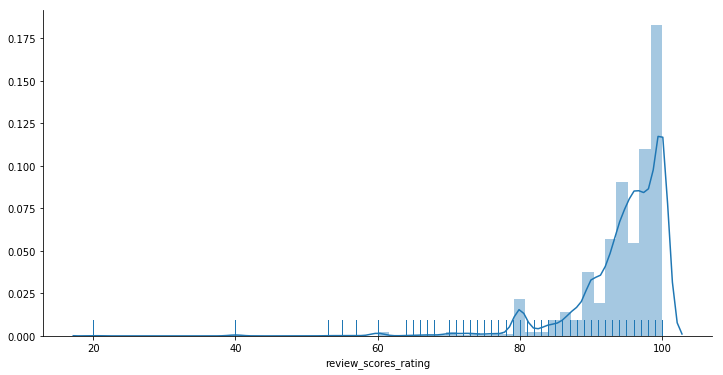

In [52]:
plt.figure(figsize=(12,6))
sns.distplot(listings.review_scores_rating.dropna(), rug=True)
sns.despine()

In [63]:
listings.review_scores_rating.describe()

count   3171.00
mean      94.54
std        6.61
min       20.00
25%       93.00
50%       96.00
75%       99.00
max      100.00
Name: review_scores_rating, dtype: float64

As expected, most of reviewers leave high scores.

### Exploring the price

In [64]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)

listings['price'].describe()

count   3818.00
mean     127.98
std       90.25
min       20.00
25%       75.00
50%      100.00
75%      150.00
max     1000.00
Name: price, dtype: float64

In [65]:
listings.iloc[np.argmax(listings['price'])]

id                                                                            4825073
listing_url                                      https://www.airbnb.com/rooms/4825073
scrape_id                                                              20160104002432
last_scraped                                                               2016-01-04
name                                                          Cute Basement Apartment
summary                             2 bedroom fully finished basement apartment wi...
space                                                                             NaN
description                         2 bedroom fully finished basement apartment wi...
experiences_offered                                                              none
neighborhood_overview                                                             NaN
notes                                                                             NaN
transit                                               

In [66]:
listings.loc[listings['price'] > 600]['price'].describe()

count     14.00
mean     807.14
std      127.27
min      673.00
25%      700.00
50%      750.00
75%      937.25
max     1000.00
Name: price, dtype: float64

In [67]:
listings.loc[listings['price'] == 0]['price'].count()

0

#### Listings price distribution after removing outliers

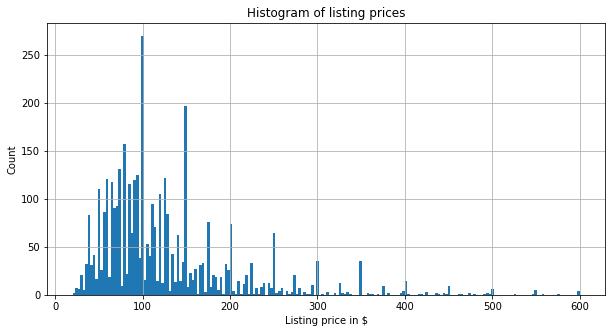

In [85]:
listings.loc[(listings.price <= 600) & (listings.price > 0)].price.hist(bins=200,figsize=(10,5))
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices');

#### Neighbourhood vs. Price

<Figure size 1152x360 with 0 Axes>

[Text(0,0,'Briarcliff'),
 Text(0,0,'Pioneer Square'),
 Text(0,0,'Industrial District'),
 Text(0,0,'Central Business District'),
 Text(0,0,'Westlake'),
 Text(0,0,'Belltown'),
 Text(0,0,'Southeast Magnolia'),
 Text(0,0,'Pike-Market'),
 Text(0,0,'Pinehurst'),
 Text(0,0,'Portage Bay'),
 Text(0,0,'Windermere'),
 Text(0,0,'First Hill'),
 Text(0,0,'Alki'),
 Text(0,0,'View Ridge'),
 Text(0,0,'West Queen Anne'),
 Text(0,0,'East Queen Anne'),
 Text(0,0,'Madrona'),
 Text(0,0,'Lawton Park'),
 Text(0,0,'Stevens'),
 Text(0,0,'Montlake'),
 Text(0,0,'Lower Queen Anne'),
 Text(0,0,'Fairmount Park'),
 Text(0,0,'Yesler Terrace'),
 Text(0,0,'Green Lake'),
 Text(0,0,'North Queen Anne'),
 Text(0,0,'Eastlake'),
 Text(0,0,'South Lake Union'),
 Text(0,0,'Whittier Heights'),
 Text(0,0,'Seaview'),
 Text(0,0,'Fauntleroy'),
 Text(0,0,'Harrison/Denny-Blaine'),
 Text(0,0,'Fremont'),
 Text(0,0,'Madison Park'),
 Text(0,0,'Phinney Ridge'),
 Text(0,0,'Laurelhurst'),
 Text(0,0,'South Park'),
 Text(0,0,'North Admiral'),
 

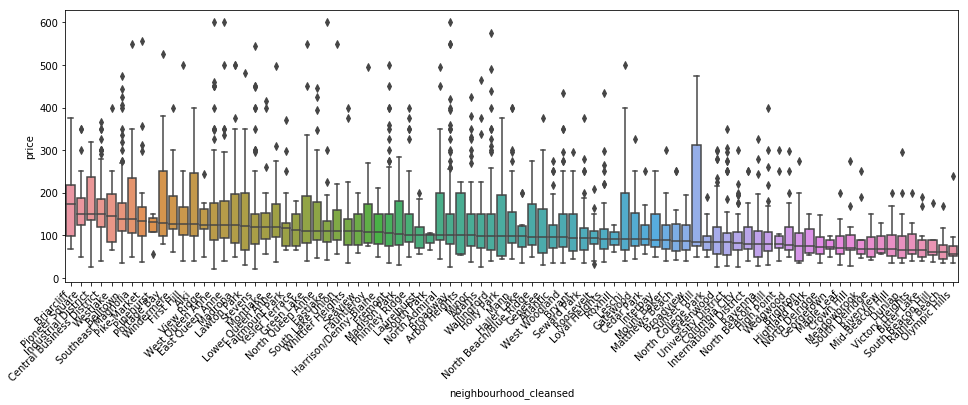

In [75]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize=(16,5))
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

Not only Waterfront Communities-The Island has the highest number of listings, it also enjoys the highest median price, and Milliken has the lowest median price.

#### host vs. price

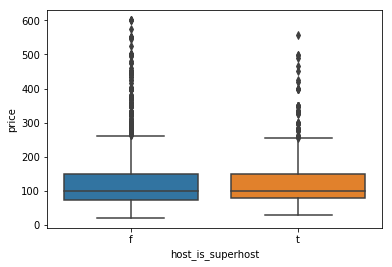

In [86]:
sns.boxplot(y='price', x='host_is_superhost', data=listings.loc[(listings.price <= 600) & (listings.price > 0)])

#### property type vs. price

[Text(0,0,'Boat'),
 Text(0,0,'Condominium'),
 Text(0,0,'Apartment'),
 Text(0,0,'Loft'),
 Text(0,0,'Yurt'),
 Text(0,0,'Bed & Breakfast'),
 Text(0,0,'Chalet'),
 Text(0,0,'Townhouse'),
 Text(0,0,'House'),
 Text(0,0,'Cabin'),
 Text(0,0,'Bungalow'),
 Text(0,0,'Other'),
 Text(0,0,'Camper/RV'),
 Text(0,0,'Tent'),
 Text(0,0,'Treehouse'),
 Text(0,0,'Dorm')]

[Text(0,0,'Boat'),
 Text(0,0,'Condominium'),
 Text(0,0,'Apartment'),
 Text(0,0,'Loft'),
 Text(0,0,'Yurt'),
 Text(0,0,'Bed & Breakfast'),
 Text(0,0,'Chalet'),
 Text(0,0,'Townhouse'),
 Text(0,0,'House'),
 Text(0,0,'Cabin'),
 Text(0,0,'Bungalow'),
 Text(0,0,'Other'),
 Text(0,0,'Camper/RV'),
 Text(0,0,'Tent'),
 Text(0,0,'Treehouse'),
 Text(0,0,'Dorm')]

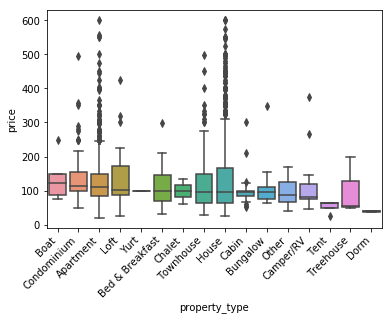

In [95]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
list(ax.get_xticklabels())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

When we look at the median price for each property type, we have to be careful that we can't say "The most expensive property type is Aparthotel, and that Tent and Parking Space have a higher median price than Apartment and Castle.", because Aparthotel, tend and parking space has only one listing each.

In [96]:
listings.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

#### room type vs. price

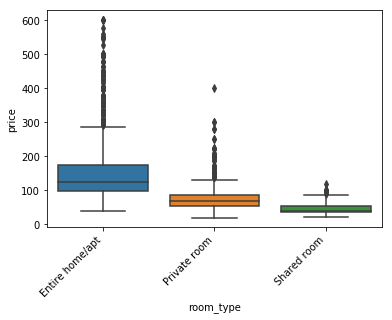

In [97]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='room_type', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

This goes without saying, entire room/apt has a a much higher median price than the other room types.

Text(0.5,0,'Listing price in $')

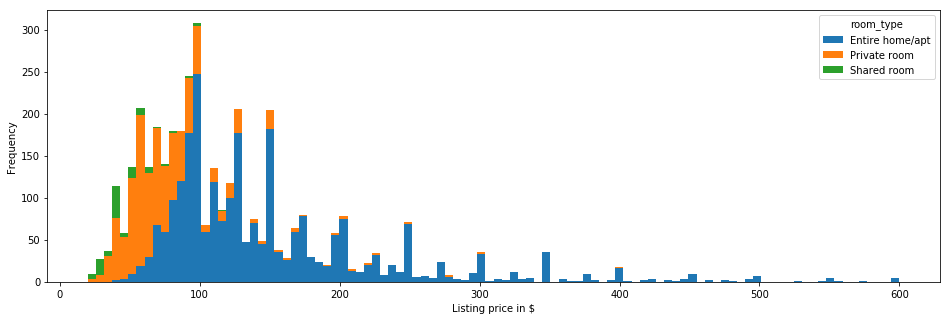

In [104]:
listings.loc[(listings.price <= 600) & (listings.price > 0)].pivot(columns = 'room_type', values = 'price').plot.hist(stacked = True, bins=100)
fig = plt.gcf()
fig.set_size_inches(16,5)
plt.xlabel('Listing price in $')

#### bed type vs. price

[Text(0,0,'Real Bed'),
 Text(0,0,'Pull-out Sofa'),
 Text(0,0,'Futon'),
 Text(0,0,'Airbed'),
 Text(0,0,'Couch')]

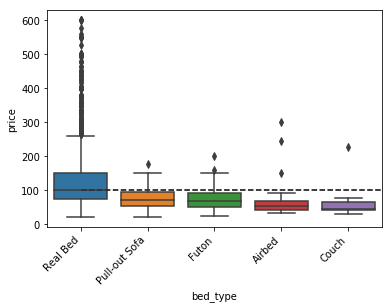

In [119]:
sort_price = listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                    .groupby('bed_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='bed_type', data=listings.loc[(listings.price <= 600) & (listings.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# plt.hlines(y=100,xmin=0,xmax=6,linestyles='--')

There is no surprise.

#### Amenities

The amenities text field needs some cleaning.

In [122]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

In [123]:
listings['amenities'].head()

0    TV,Cable TV,Internet,Wireless Internet,Air Con...
1    TV,Internet,Wireless Internet,Kitchen,Free Par...
2    TV,Cable TV,Internet,Wireless Internet,Air Con...
3    Internet,Wireless Internet,Kitchen,Indoor Fire...
4    TV,Cable TV,Internet,Wireless Internet,Kitchen...
Name: amenities, dtype: object

#### Top 20 most common amenities

[Text(0,0,'Wireless Internet'),
 Text(0,0,'Heating'),
 Text(0,0,'Kitchen'),
 Text(0,0,'Smoke Detector'),
 Text(0,0,'Essentials'),
 Text(0,0,'Dryer'),
 Text(0,0,'Washer'),
 Text(0,0,'Internet'),
 Text(0,0,'Shampoo'),
 Text(0,0,'TV'),
 Text(0,0,'Carbon Monoxide Detector'),
 Text(0,0,'Fire Extinguisher'),
 Text(0,0,'Free Parking on Premises'),
 Text(0,0,'Family/Kid Friendly'),
 Text(0,0,'First Aid Kit'),
 Text(0,0,'Cable TV'),
 Text(0,0,'Indoor Fireplace'),
 Text(0,0,'Pets live on this property'),
 Text(0,0,'Hangers'),
 Text(0,0,'Elevator in Building')]

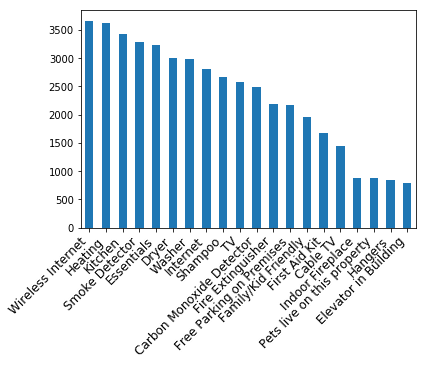

In [129]:
pd.Series(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

Wifi, heating, essential, kitchen and smoke detector etc are among the most common amenities.

#### Amenities vs. price top 20

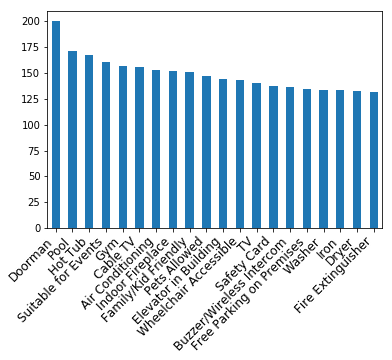

In [139]:
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))
amenity_prices = [(amn, listings[listings['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])

amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

#### Number of beds vs. price

Text(0.5,0,'Listing price in $')

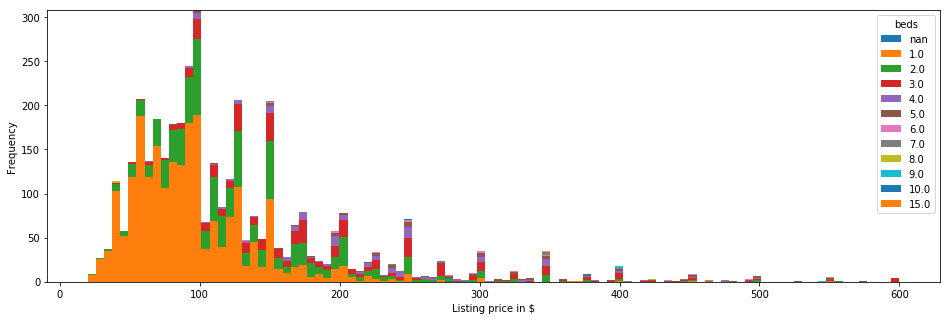

In [141]:
listings.loc[(listings.price <= 600) & (listings.price > 0)].pivot(columns = 'beds',values = 'price').plot.hist(stacked = True,bins=100)
fig = plt.gcf()
fig.set_size_inches(16,5)
plt.xlabel('Listing price in $')

Vast majority of the listings have one bed, the one-bed listing prices have a very wide range. There are listings that have no bed.

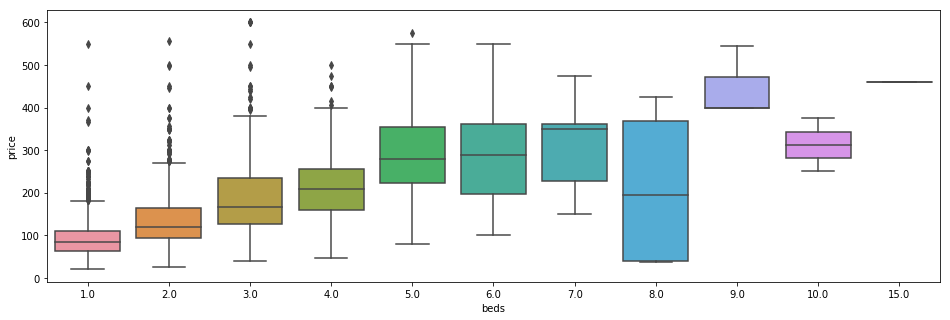

In [142]:
sns.boxplot(y='price', x='beds', data = listings.loc[(listings.price <= 600) & (listings.price > 0)])
fig = plt.gcf()
fig.set_size_inches(16,5)

Interesting to discover that the median price for no bed listings is higher than 1-bed and 2-bed listings, and median price for 10-bed listings is very low.

#### numeric features

We select several numeric features and try to explore them all together.

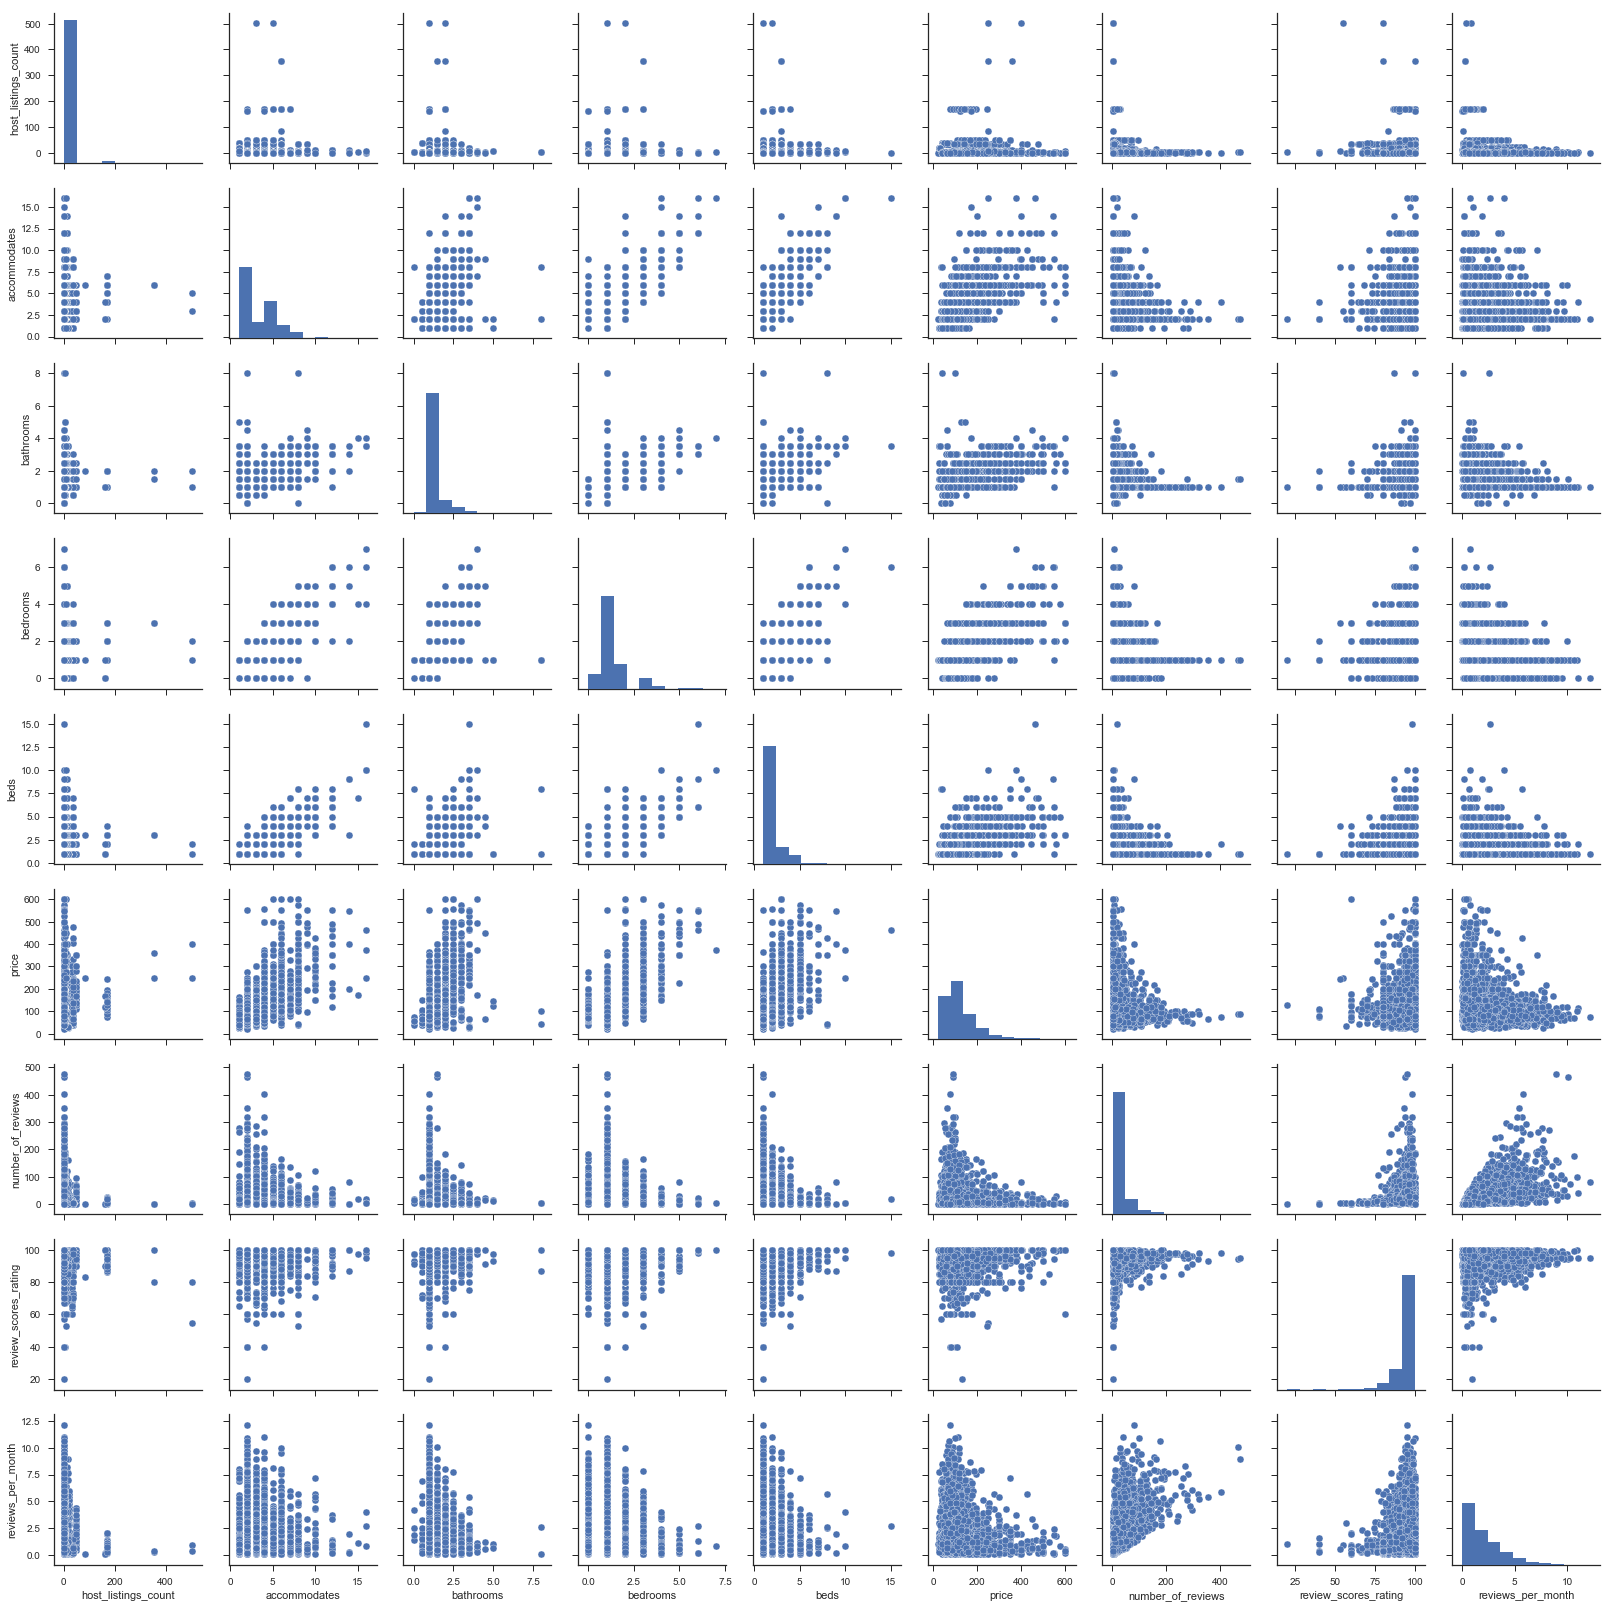

In [143]:
col = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']
sns.set(style="ticks", color_codes=True)
sns.pairplot(listings.loc[(listings.price <= 600) & (listings.price > 0)][col].dropna())

<Figure size 432x432 with 0 Axes>

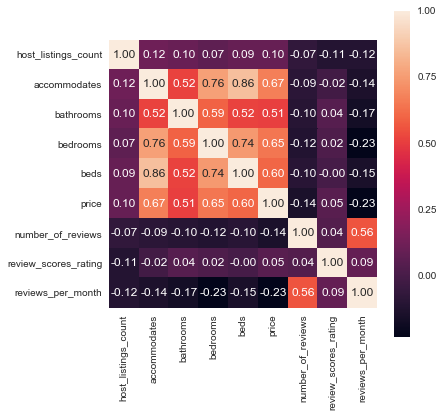

In [145]:
corr = listings.loc[(listings.price <= 600) & (listings.price > 0)][col].dropna().corr()
plt.figure(figsize = (6,6))
# sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)

There are some not bad news such as number of bedrooms and accommodates seem to be correlated with price.

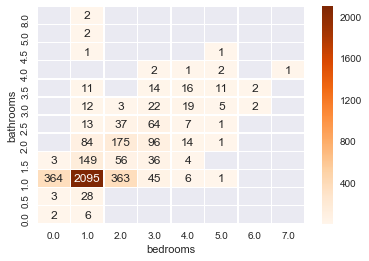

In [146]:
sns.heatmap(listings.loc[(listings.price <= 600) & (listings.price > 0)]\
                .groupby(['bathrooms', 'bedrooms'])\
                .count()['price']\
                .reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Oranges", fmt='.0f', annot=True, linewidths=0.5)
plt.show();

Vast majority of listings have one bedroom and 1 bathroom.

## Modeling Lising Prices

### Data preprocessing and feature engineering

In [158]:
listings = pd.read_csv('e:/data/seattle/listings.csv')
listings[:3]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.00,f,nan,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.00,f,nan,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.00,f,nan,WASHINGTON,f,strict,f,f,2,1.15


Processing price feature. The feature we are going to model and predict.

In [159]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)
listings = listings.loc[(listings.price <= 600) & (listings.price > 0)]

Term document matrix for amenities feature.

In [160]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

In [161]:
listings.amenities.head()

0    TV,Cable TV,Internet,Wireless Internet,Air Con...
1    TV,Internet,Wireless Internet,Kitchen,Free Par...
3    Internet,Wireless Internet,Kitchen,Indoor Fire...
4    TV,Cable TV,Internet,Wireless Internet,Kitchen...
5    Wireless Internet,Free Parking on Premises,Hea...
Name: amenities, dtype: object

In [187]:
#============method 1==============
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listings['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)
df_amenities[:3]
#============method 2==============
s1 = listings.amenities
s2 = s1.str.split(',')
s3 = s2.apply(lambda x:Series(1,index=x)).fillna(0).astype('int')
s3[:3]

,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,...,safety card,shampoo,smoke detector,smoking allowed,suitable for events,tv,washer,washer / dryer,wheelchair accessible,wireless internet
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,1,0,1,0,0,1,1,0,0,1
2,0,0,0,0,0,1,0,0,0,1,...,1,1,1,0,0,0,1,0,0,1


,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,0,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,1,1,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,1,0,0,1


Replace the values in the following feature to 0 if "f", to 1 if "t".

In [188]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

Same way to clean up the other money value columns.

In [189]:
listings['security_deposit'] = listings['security_deposit'].fillna(value=0)
listings['security_deposit'] = listings['security_deposit'].replace( '[\$,)]','', regex=True ).astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(value=0)
listings['cleaning_fee'] = listings['cleaning_fee'].replace( '[\$,)]','', regex=True ).astype(float)

The following are the numeric features we will be using.

In [190]:
listings_new = listings[['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','is_location_exact', 
                         'requires_license', 'instant_bookable', 'require_guest_profile_picture', 
                         'require_guest_phone_verification', 'security_deposit', 'cleaning_fee', 
                         'host_listings_count', 'host_total_listings_count', 'minimum_nights',
                     'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews','review_scores_rating', 'price']]

Fill the missing values in the numeric features with median.

In [191]:
for col in listings_new.columns[listings_new.isnull().any()]:
    print(col)

host_is_superhost
host_identity_verified
host_has_profile_pic
host_listings_count
host_total_listings_count
bathrooms
bedrooms
review_scores_rating


In [192]:
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())

D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Processing Categorical features

In [193]:
for cat_feature in ['zipcode', 'property_type', 'room_type', 'cancellation_policy', 'neighbourhood_cleansed', 'bed_type']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)

Adding amenities feature

In [194]:
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')

Data preprocessing and feature engineering done!

In [195]:
listings_new[:3]

,host_is_superhost,host_identity_verified,host_has_profile_pic,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,security_deposit,cleaning_fee,...,safety card,shampoo,smoke detector,smoking allowed,suitable for events,tv,washer,washer / dryer,wheelchair accessible,wireless internet
0,0.00,1.00,1.00,1,0,0,0,0,0.00,0.00,...,0,0,0,0,0,1,1,0,0,1
1,1.00,1.00,1.00,1,0,0,1,1,100.00,40.00,...,1,0,1,0,0,1,1,0,0,1
3,0.00,1.00,1.00,1,0,0,0,0,0.00,0.00,...,0,1,1,0,0,1,0,0,0,1


### Random Forest Regressor

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=3, verbose=0, warm_start=False)

RMSE test: 47.464
R^2 test: 0.625


#### Feature importance of Random Forest

In [198]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
14,bedrooms,0.43
13,bathrooms,0.07
9,cleaning_fee,0.07
62,Entire home/apt,0.06
8,security_deposit,0.03
16,number_of_reviews,0.02
17,review_scores_rating,0.02
15,guests_included,0.01
12,minimum_nights,0.01
10,host_listings_count,0.01


### LightGBM

In [199]:
from lightgbm import LGBMRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }

In [200]:
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')

In [201]:
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)

Training until validation scores don't improve for 20 rounds.
[100]	valid's rmse: 53.9386
[200]	valid's rmse: 49.1496
[300]	valid's rmse: 47.9446
[400]	valid's rmse: 47.3008
[500]	valid's rmse: 47.1289
[600]	valid's rmse: 47.0466
Early stopping, best iteration is:
[611]	valid's rmse: 47.0183


LGBMRegressor_GainFE(boosting_type='gbdt', class_weight=None,
           colsample_bytree=0.9, importance_type='split',
           learning_rate=0.01, max_depth=20, metric='rmse',
           min_child_samples=20, min_child_weight=0.001,
           min_split_gain=0.0, n_estimators=1000, n_jobs=4, num_leaves=25,
           objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
           silent=True, subsample=0.9, subsample_for_bin=200000,
           subsample_freq=0)

In [202]:
y_pred = clf.predict(X_test.values)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

R^2 test: 0.632


#### Feature importance of LightGBM

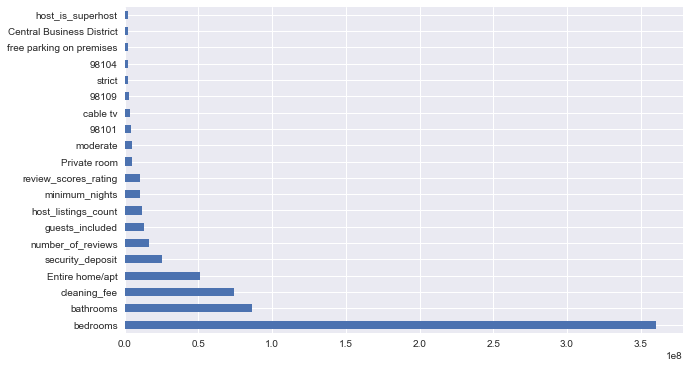

In [204]:
feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))